# Transfer learning (domain shift quantification)

After an appropiate model has been developed in phase 1, the goal is to extend the previous knowledge to a second population. To do so, we aim to follow the next steps: 

1. Quantification of the domain shift
2. Modelling on phase 2 (depending on the degree of domain shift)
- 2.1. Semi-supervised learning (use of the small subset of labelled data for learning)
- 2.2. Self-supervised learning (use model of phase 1 to label the data of phase 2)
- 2.2. Unsupervised domain adaptation (align phase 1 and phase 2 distributions in a common latent space)

(Some other approaches to face domain shift: 
- Domain Adversarial Training: Here, models are trained to have representations which cannot be easily distinguished between source and target using a domain discriminator.
- Subspace Alignment: Methods like CORrelation ALignment (CORAL) minimize domain shift by aligning the second-order statistics (covariance) of source and target features.
- Instance Re-weighting: Source instances are re-weighted based on their similarity to the target domain.
- Fine-tuning: After pre-training a model on the source domain, it is fine-tuned on a small labeled dataset from the target domain.)

In [56]:
import os
import numpy as np
import pandas as pd
import importlib
import joblib
from sklearn.neighbors import BallTree
import prince
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from scipy.stats import ks_2samp, chi2_contingency, entropy


# import from custom package
from auxFuns.EDA import *
from auxFuns.modelling import *
from auxFuns.class_overlap import *
from auxFuns.transfer_learning import *

In [57]:
import auxFuns.EDA 
importlib.reload(auxFuns.EDA)

import auxFuns.modelling
importlib.reload(auxFuns.modelling)

import auxFuns.class_overlap
importlib.reload(auxFuns.class_overlap)

import auxFuns.transfer_learning
importlib.reload(auxFuns.transfer_learning)

<module 'auxFuns.transfer_learning' from 'c:\\Users\\angel\\Documents\\VSCode\\rsv_modelling_transfer_learning\\auxFuns\\transfer_learning.py'>

## Load data and motivation for transfer learning

In [4]:
# Load of the data and filter in the needed features

raw_datasets_path = os.getcwd() + '/datasets/raw'
processed_datasets_path = os.getcwd() + '/datasets/processed'

# Phase 1 data
rsv_predictors_df_v2 = pd.read_csv(processed_datasets_path + '/rsv_predictors_phase1_daysDedup_seasons_prevTest_v2.csv',low_memory=False)
rsv_predictors_phase1_df = make_it_categorical_v2(rsv_predictors_df_v2)

# Phase 2 data
rsv_phase2_df = pd.read_csv(processed_datasets_path + '/rsv_phase2_all_features.csv',low_memory=False)
rsv_phase2_df = make_it_categorical_v2(rsv_phase2_df, is_phase1 = False)

# Small subset of labelled data of phase 2:
labels_phase2_df = pd.read_csv(raw_datasets_path + '/rsv_test_phase2.csv',low_memory=False)
labels_phase2_df = labels_phase2_df.rename(columns = {'RSV_test_date':'index_date'})

# Compatibility issue detected: merging labelled and unlabelled data is challening due to incompatible date columns
rsv_phase2_df.index_date = pd.to_datetime(rsv_phase2_df.index_date)
labels_phase2_df.index_date = pd.to_datetime(labels_phase2_df.index_date)

rsv_phase2_labelled_df = labels_phase2_df.merge(rsv_phase2_df, how='left', on=['patient_id', 'index_date'])
# rsv_phase2_labelled_df = labels_phase2_df.merge(rsv_phase2_df, how='left', on=['patient_id'])
rsv_phase2_labelled_df = rsv_phase2_labelled_df.dropna()

rsv_predictors_phase1_df.shape, rsv_phase2_df.shape, rsv_phase2_labelled_df.shape

((86058, 64), (291938, 63), (2867, 64))

In [5]:
# Only 2003 of the 3073 (~65%) patients who underwent a RSV test are present in the whole populations's dataset
patient_ids_rsv_test = labels_phase2_df.patient_id.unique()
patient_ids_phase2 = rsv_phase2_df.patient_id.unique()

len(patient_ids_rsv_test), len(patient_ids_phase2), (pd.Series(patient_ids_rsv_test).isin(patient_ids_phase2)).sum()

(3073, 40507, 2003)

In [6]:
# This agrees with the results of the previous check
unique_patients_rsv_test = len(rsv_phase2_labelled_df.patient_id.unique())
print(f'Number of unique patients with a rsv test in phase 2 data: {unique_patients_rsv_test}')

negative_tests = rsv_phase2_labelled_df.RSV_test_result.value_counts()[0]
positive_tests = rsv_phase2_labelled_df.RSV_test_result.value_counts()[1]
IR_phase2 = negative_tests / positive_tests
p_pos_phase2 = (positive_tests / (positive_tests + negative_tests))*100
print(f'\nImbalance ratio in the phase 2 labelled data: {IR_phase2}')
print(f'Percentage of positives phase 2: {p_pos_phase2}')
# the imbalance is heavier than in phase 1 (1.8% of positives vs ~3.0% in phase 1)

Number of unique patients with a rsv test in phase 2 data: 1717

Imbalance ratio in the phase 2 labelled data: 54.13461538461539
Percentage of positives phase 2: 1.8137425880711544


In [11]:
# summary_function_rsv(rsv_phase2_df, is_phase1 = False)

In [7]:
selected_features = ['sex', 'marital_status', 'race','patient_regional_location', 'age_group',
                     'Acute_upper_respiratory_infection','Influenza','Pneumonia','Bronchitis','Symptoms_and_signs__digestive_system_and_abdomen','General_symptoms_and_signs','any_symptom',
                     'COPD','AIDS','Asthma_chronic','CCI',
                     'sine','cosine','calendar_year', 
                     'healthcare_seeking', 'influenza_vaccine',
                     'n_symptoms','prev_positive_rsv','previous_test_daydiff','n_immunodeficiencies', 
                     'tumor_indicator','tumor_last_year',
                     'season',
                     'n_tests_that_day']
selected_features_v1 = ['n_tests_that_day', 'sine','cosine', 'previous_test_daydiff',
                     'Bronchitis', 'CCI',
                     'Acute_upper_respiratory_infection', 'n_immunodeficiencies', 'n_symptoms',
                     'healthcare_seeking', 
                     'General_symptoms_and_signs', 'prev_positive_rsv', 'Influenza',
                     'season','multiple_tests']
selected_features_v2 = ['n_tests_that_day', 'sine','cosine', 'previous_test_daydiff',
                     'Bronchitis', 'CCI',
                     'Acute_upper_respiratory_infection', 'n_immunodeficiencies', 'n_symptoms',
                     'healthcare_seeking', 
                     'General_symptoms_and_signs', 'prev_positive_rsv', 'Influenza',
                     'key_comorbidities','Pneumonia',
                     'season','month_of_the_test','multiple_tests',
                     'BPA','BPAI']
selected_features_v3 = selected_features_v2 + ['race', 'age_group','marital_status','sex',
                                                    'patient_regional_location','calendar_year']

selected_features_v2_aux = selected_features_v2.copy()
selected_features_v1.append('RSV_test_result')
selected_features_v2.append('RSV_test_result')
selected_features_v3.append('RSV_test_result')

In [8]:
df_modelling_phase1 = rsv_predictors_phase1_df[selected_features_v2]
df_modelling_phase2 = rsv_phase2_labelled_df[selected_features_v2]
df_modelling_all_phase2 = rsv_phase2_df[selected_features_v2_aux]

df_modelling_phase1.shape, df_modelling_phase2.shape, df_modelling_all_phase2.shape

((86058, 21), (2867, 21), (291938, 20))

In [9]:
# Let us just run the models validated in phase 1 population, and see how they perform in this 
phase1_models_path = os.getcwd() + '/models/models_phase1'

model_nonOverlapping_phase1 = joblib.load(phase1_models_path + '/nonOverlapping_rfc_8020_nofamd.joblib')
model_Overlapping_phase1 = joblib.load(phase1_models_path + '/Overlapping_rfc_8020_nofamd.joblib')

# A small preprocessing step needs to be implemented ad-hoc:
df_modelling_phase2.loc[:,'n_tests_that_day'] = pd.Categorical(df_modelling_phase2.n_tests_that_day, categories=[1,2])

In [15]:
# As we do not know if the points fall in the overlapping or non overlapping region, we will do a soft vote for both
X_test_phase2 =  pd.get_dummies(df_modelling_phase2.drop(['RSV_test_result'], axis = 1))
y_test_phase2 = df_modelling_phase2['RSV_test_result']

preds_proba_nonOverlapping = model_nonOverlapping_phase1.predict_proba(X_test_phase2)[:,1]
preds_proba_Overlapping = model_Overlapping_phase1.predict_proba(X_test_phase2)[:,1]

y_probs = (preds_proba_nonOverlapping + preds_proba_Overlapping)/2

optimal_thr_nonOverlapping = find_optimal_moving_threshold_from_probas(preds_proba_nonOverlapping, y_test = y_test_phase2)
optimal_thr_Overlapping = find_optimal_moving_threshold_from_probas(preds_proba_Overlapping, y_test = y_test_phase2)
optimal_thr_aggregated = find_optimal_moving_threshold_from_probas(y_probs = y_probs, y_test = y_test_phase2)
# the optimal threshold is found for the soft-voting approach in the aggregated part

__, __, __, __, __, __, __, __ = calculate_performance_metrics_from_probas(y_probs = y_probs, y_test = y_test_phase2, threshold = optimal_thr_aggregated, print_roc = False, print_pr = False)


Optimal threshold: 0.02
Optimal f1: 0.039999999999999994


Optimal threshold: 0.46
Optimal f1: 0.04520654715510523


Optimal threshold: 0.27
Optimal f1: 0.04788507581803671


AUC Score: 0.5273500478207405
Precision / Positive predictive value: 0.02497918401332223
Specificity: 0.5840142095914742
Recall / sensitivity: 0.5769230769230769
Negative predictive value: 0.9867947178871549
Accuracy: 0.5838855946982909
F-1: 0.04788507581803671
Precision-Recall AUC: 0.046646476037127405


In [23]:
# Let us evaluate a second approach:
# Calculate the N1 metric for the new data and divide overlapping and non-overlapping accordingly
X_test_phase2 =  pd.get_dummies(df_modelling_phase2.drop(['RSV_test_result'], axis = 1))
y_test_phase2 = df_modelling_phase2['RSV_test_result']

print('Finding overlapping regions in phase 2 data')
#1. Ball tree
print('Build-up of the ball tree ...')
tree_phase2 = BallTree(X_test_phase2)

# 2: tree-guided closest neighbour
print('Finding closest neighbour in the ball tree for every instance ...')
dist2, ind2 = tree_phase2.query(X_test_phase2, k=2)

# Step 4: same class neighbours
print('Determination of instances with a same-class neighbour ...')
labels = y_test_phase2.to_numpy()
same_class_neighbours_phase2 = labels[ind2[:, 0]] == labels[ind2[:, 1]]
N1_phase2 = 1 - np.mean(same_class_neighbours_phase2)

print('\nDone!')
print(f'N1 metric for phase 2 labelled data: {N1_phase2}')

Finding overlapping regions in phase 2 data
Build-up of the ball tree ...
Finding closest neighbour in the ball tree for every instance ...
Determination of instances with a same-class neighbour ...

Done!
N1 metric for phase 2 labelled data: 0.029647715381932338


In [31]:
# Divide the data in overlapping and non overlapping
X_test_phase2_nonOverlapping = X_test_phase2.loc[same_class_neighbours_phase2 == True,:]
X_test_phase2_Overlapping = X_test_phase2.loc[same_class_neighbours_phase2 == False,:]

y_test_phase2_nonOverlapping = y_test_phase2.loc[same_class_neighbours_phase2 == True]
y_test_phase2_Overlapping = y_test_phase2.loc[same_class_neighbours_phase2 == False]

y_test_phase2_nonOverlapping.value_counts(), y_test_phase2_Overlapping.value_counts()

(RSV_test_result
 Negative    2770
 Positive      12
 Name: count, dtype: int64,
 RSV_test_result
 Negative    45
 Positive    40
 Name: count, dtype: int64)

In [52]:
# Now, calculate the performance metrics of every region
# Non-overlapping
print('----------------------------------')
print('Non-overlapping region performance')

preds_proba_nonOverlapping = model_nonOverlapping_phase1.predict_proba(X_test_phase2_nonOverlapping)[:,1]
optimal_thr_nonOverlapping = find_optimal_moving_threshold_from_probas(preds_proba_nonOverlapping, y_test = y_test_phase2_nonOverlapping)
__, __, __, __, __, __, __, __ = calculate_performance_metrics_from_probas(y_probs = preds_proba_nonOverlapping, y_test = y_test_phase2_nonOverlapping, 
                                                                            threshold = optimal_thr_nonOverlapping, print_roc = False, print_pr = False)

print('\n----------------------------------')
print('(yes) Overlapping region performance')

preds_proba_Overlapping = model_Overlapping_phase1.predict_proba(X_test_phase2_Overlapping)[:,1]
optimal_thr_Overlapping = find_optimal_moving_threshold_from_probas(preds_proba_Overlapping, y_test = y_test_phase2_Overlapping)
__, __, __, __, __, __, __, __ = calculate_performance_metrics_from_probas(y_probs = preds_proba_Overlapping, y_test = y_test_phase2_Overlapping, 
                                                                            threshold = optimal_thr_Overlapping, print_roc = False, print_pr = False)

print('\n----------------------------------')
print('Aggregated metrics')
probs_all = np.concatenate([preds_proba_nonOverlapping, preds_proba_Overlapping], axis = 0)
y_test_all = pd.concat([y_test_phase2_nonOverlapping,y_test_phase2_Overlapping], axis = 0)

optimal_thr_all = find_optimal_moving_threshold_from_probas(probs_all, y_test = y_test_all)
__, __, __, __, __, __, __, __ = calculate_performance_metrics_from_probas(y_probs = probs_all, y_test = y_test_all, 
                                                                            threshold = optimal_thr_all, print_roc = False, print_pr = False)

----------------------------------
Non-overlapping region performance
Optimal threshold: 0.72
Optimal f1: 0.028481012658227847


AUC Score: 0.7279031287605295
Precision / Positive predictive value: 0.014516129032258065
Specificity: 0.7794223826714801
Recall / sensitivity: 0.75
Negative predictive value: 0.9986123959296948
Accuracy: 0.7792954708842559
F-1: 0.028481012658227847
Precision-Recall AUC: 0.0909978023569105

----------------------------------
(yes) Overlapping region performance
Optimal threshold: 0.13
Optimal f1: 0.6446280991735537


AUC Score: 0.5283333333333333
Precision / Positive predictive value: 0.48148148148148145
Specificity: 0.06666666666666667
Recall / sensitivity: 0.975
Negative predictive value: 0.75
Accuracy: 0.49411764705882355
F-1: 0.6446280991735537
Precision-Recall AUC: 0.48997390458275353

----------------------------------
Aggregated metrics
Optimal threshold: 0.16
Optimal f1: 0.0818815331010453


AUC Score: 0.7184895477524251
Precision / Positive predictiv

**Motivation for transfer learning:** As we suspected, the model developed in phase 1 fails to generalize for phase 2 population.

Interestengly enough, the model from phase 1 is biased to positive instances. This leads to excelent recall values (~90% of positive samples are identified) while low performing precision values (~4% of positives are true positives).

## 1. Quantification of the domain shift

Let us keep in mind 3 types of domain shift we may be facing:
- Covariate shift (changes in P(X))
- Label shift/prior probability shift (changes in P(y))
- Concept drift (changes in P(y|X))

Some sources (e.g. [1] classify the two first as diversity shift and the latter as correlation shift)

To gain an idea of the domain shift in our distributions, let us:

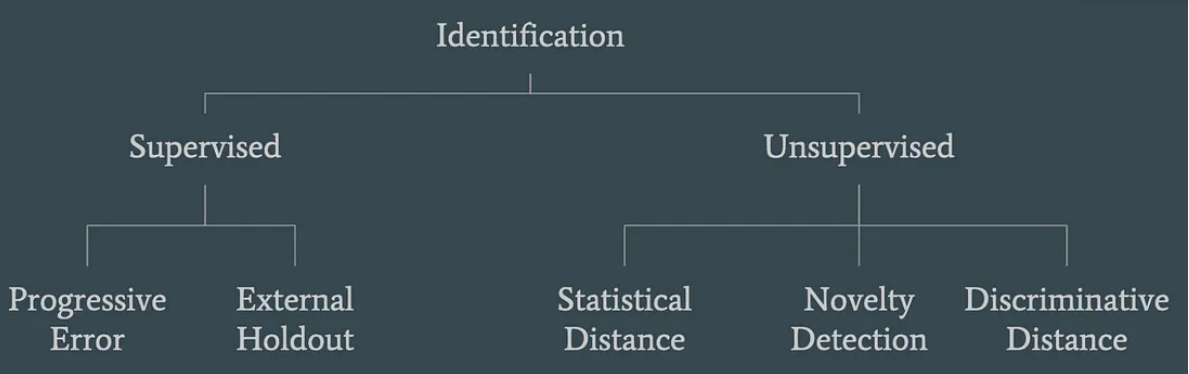

*Supervised* identification methods rely mainly on the evaluation of performance in a validation set of the new distribution of the previously developed model. As our data is mainly 

- Statistical distance (**one dimensional approach**) > histograms of values and two-sample tests.



Other methods rely on the use of alternative techniques, e.g. explainability of the model in the source population vs the out of domain (OOD) distribution [2]

[1]: Ye, Nanyang, et al. "Ood-bench: Quantifying and understanding two dimensions of out-of-distribution generalization." Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition. 2022.
[2] Mougan, C., Broelemann, K., Kasneci, G., Tiropanis, T., & Staab, S. (2022). Explanation Shift: Detecting distribution shifts on tabular data via the explanation space. arXiv preprint arXiv:2210.12369.



### Visualization of the two populations

Let us start by visualizing both populations to understand how they look like

In [10]:
# differentiate between labelled and non-labelled data in phase 2
labelled_data_phase2_mask = rsv_phase2_labelled_df.index
labelled_mask = rsv_phase2_df.index.isin(labelled_data_phase2_mask)
non_labelled_mask = ~rsv_phase2_df.index.isin(labelled_data_phase2_mask)

df_modelling_all_phase2.loc[non_labelled_mask, 'phase'] = '2_No_label'
df_modelling_all_phase2.loc[labelled_mask, 'phase'] = '2_label'
df_modelling_phase1.loc[:,'phase'] = '1'

df_modelling_both_phases = pd.concat([df_modelling_phase1, df_modelling_all_phase2], axis = 0)

df_modelling_both_phases.phase.value_counts()


phase
2_No_label    289071
1              86058
2_label         2867
Name: count, dtype: int64

In [29]:
# create a df_visualization for all phases
random_seed = 42
n_components = 5

# The size of the dataframe makes it not possible to handle, so let us sample it
sample_size = 40000
aux_df = df_modelling_both_phases.sample(n = sample_size, random_state = random_seed)

X_all = aux_df.drop(['RSV_test_result'], axis = 1)

famd = prince.FAMD(n_components=n_components, random_state=random_seed)
famd = famd.fit(X_all)

df_allphases_visualization = famd.transform(X_all)

# Ensure both df1 and df5_visualization present the same records in the same order
aux_df = aux_df.sort_index()
df_allphases_visualization = df_allphases_visualization.sort_index()

assert all(aux_df.index == df_allphases_visualization.index), "The indices of df and df_visualization do not match."

df_allphases_visualization.loc[:,'phase'] = aux_df['phase']
df_allphases_visualization.phase.value_counts()

phase
2_No_label    30680
1              9016
2_label         304
Name: count, dtype: int64

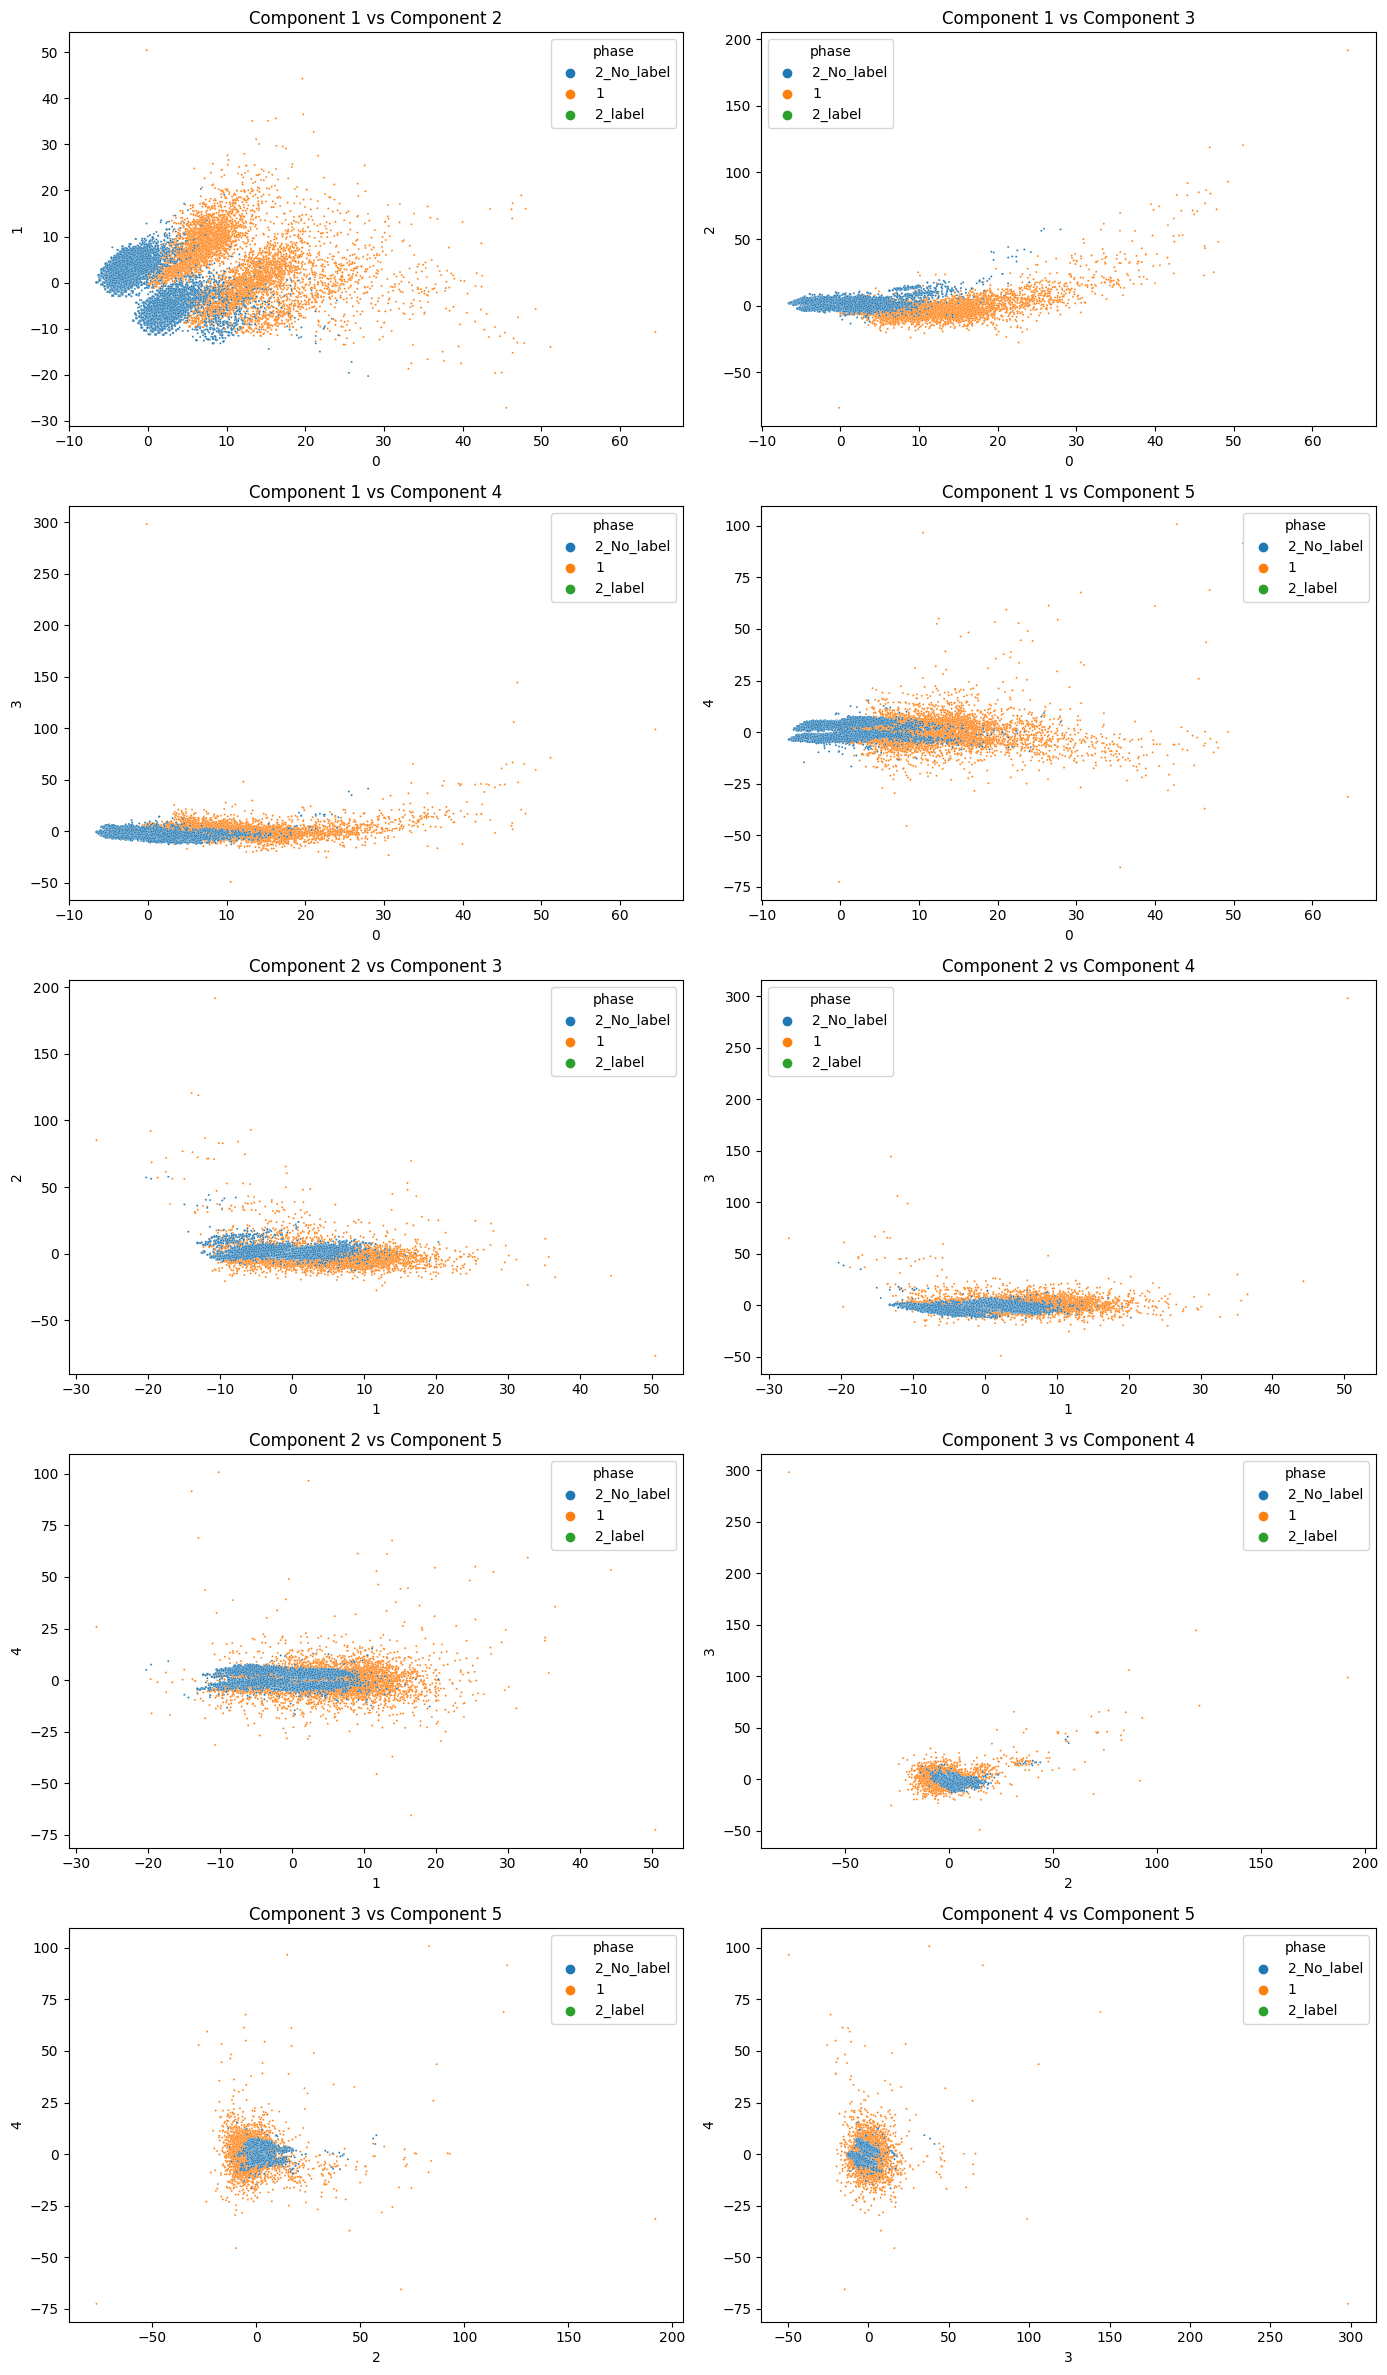

In [31]:
plot_5FMDA_planes(df = df_allphases_visualization, hue_target = 'phase', s_size = 2)

Two main obsrvations:
- Phase 2 data is much more condesed than phase 1 data (i.e. there are many more instances belonging to phase 2 but they occupy a smaller area in the plot)
- Although there is some degree of overlap between the two phases, a shift seems to be very present.

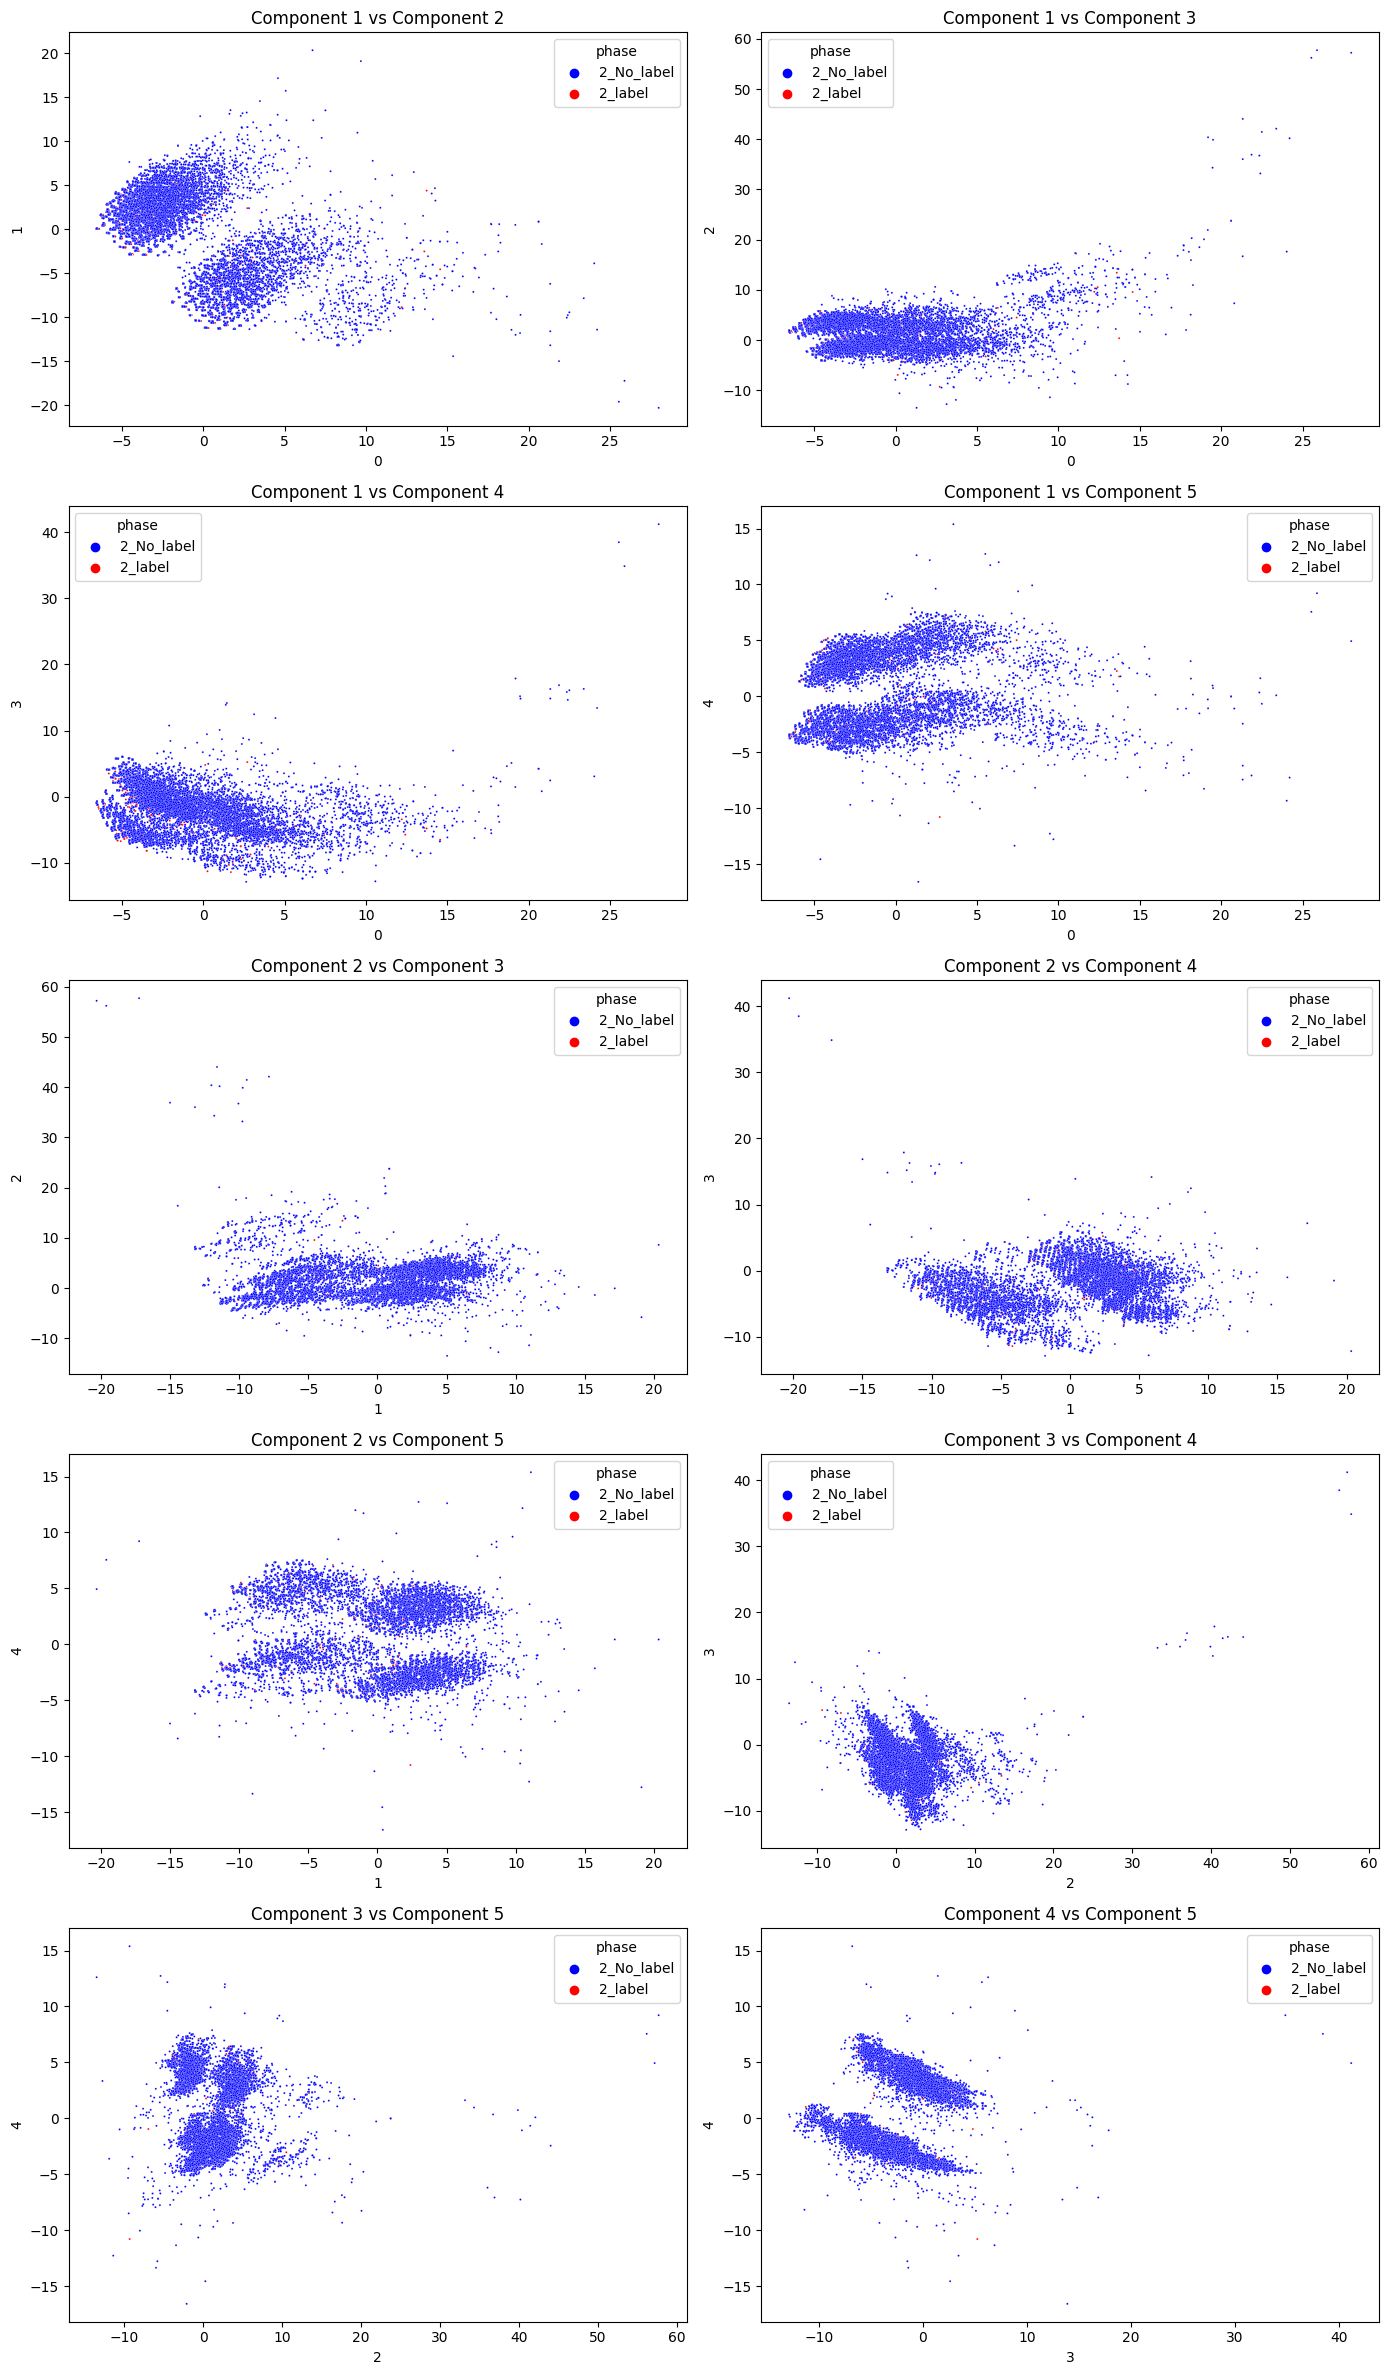

In [35]:
# Now, let us just plot the data for phase 2. The goal is to evaluate how representative the labelled data is for the rest of the population
aux_visualization_phase2 = df_allphases_visualization.loc[~(df_allphases_visualization.phase == '1'),:]
plot_5FMDA_planes(df = aux_visualization_phase2, hue_target = 'phase', palette = {'2_No_label':'blue', '2_label':'red'}, s_size = 2)

They do seem to come from the same distribution, although there are too few to be representative of the whole population

### Unsupervised methods for domain shift: discriminative distance [3]

This approach consists on the training of a classifier which aims to differentiate between a point belongig to the source or target domain. Then, the error of the training set ** gives a measure of how easy it is to differentiate between both domains.

[3] Mu, Y., Ding, W., & Tao, D. (2013). Local discriminative distance metrics ensemble learning. Pattern Recognition, 46(8), 2337-2349.

** Why on the training set? We are not interested in the generalization capabilities of the model, but just in how well a classifier is able to differentiate between one and the other (between target and source) instances.

In [24]:
df_modelling_both_phases.loc[:,'phase_v2'] = [1 if phase_label == '1' else 2 for phase_label in df_modelling_both_phases.phase]
# df_modelling_both_phases.phase_v2.value_counts()

df_modelling_DA = df_modelling_both_phases.drop(['RSV_test_result', 'phase'], axis = 1)

# Now, fitting of a model and evaluation of the error metric
X_modelling_DA = pd.get_dummies(df_modelling_DA.drop(['phase_v2'], axis = 1))
labels_DA = df_modelling_DA['phase_v2']

# Take different types of classifiers and see how they perform. This may reveal how similar our source and target distributions are
# DA_dictionary = {
#     'model': [RandomForestClassifier(), LogisticRegression(), SVC()],
#     'error_rate': [0, 0, 0],
#     'y_probs': [None, None, None]
# }
DA_dictionary = {
    'model': [RandomForestClassifier(), LogisticRegression()],
    'error_rate': [0, 0],
    'y_probs': [None, None]
}
for ii in range(len(DA_dictionary['model'])):
    clf = DA_dictionary['model'][ii]
    X_train, X_test, y_train, y_test = train_test_split(X_modelling_DA, labels_DA, test_size = 0.6, stratify = labels_DA)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    y_probs = clf.predict_proba(X_test)[:,1]
    DA_dictionary['y_probs'][ii] = y_probs

    acc = accuracy_score(y_test, y_pred)
    error = 1 - acc
    DA_dictionary['error_rate'][ii] = error

    print(f'Error rate of: {error}')
    

Error rate of: 0.004373936278097679
Error rate of: 0.7724935845995115


phase_v2
2    175163
1     51635
Name: count, dtype: int64
174409 52378


(array([4.5989e+04, 3.6910e+03, 1.2660e+03, 4.4300e+02, 3.3600e+02,
        2.1700e+02, 1.4300e+02, 9.5000e+01, 1.1100e+02, 8.7000e+01,
        7.9000e+01, 1.0400e+02, 6.3000e+01, 9.8000e+01, 6.1000e+01,
        7.9000e+01, 1.2900e+02, 2.1100e+02, 1.4460e+03, 1.7215e+05]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

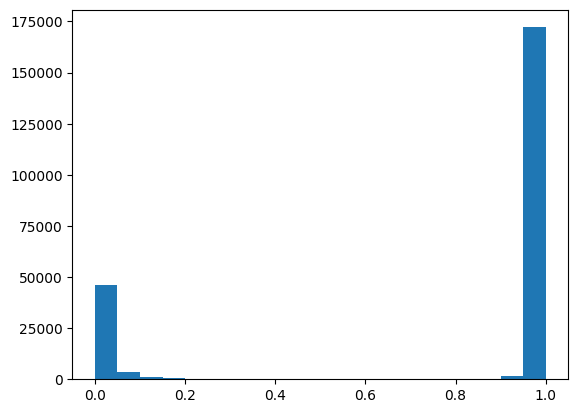

In [27]:
# print(labels_DA.value_counts())
print(y_test.value_counts())
y_probs = DA_dictionary['y_probs'][0]
print((y_probs > 0.5).sum(), (y_probs < 0.5).sum())
plt.hist(y_probs, bins = 20)

Discriminant analysis does not bring final conclusions on having very distinct populations, although the randomforest achieved a very high accuracy in differentiating between source and target populations.

The results seem to reveal more about the classifier's ability to model the data rather than the true difference between the domains.

### Unsupervised methods for domain shift: novelty detection (and outlier detection)

Novelty detection [4] is a well-known method whose purpose is to model the distribution of the source population and identify if the new points (of the target population) belong or not to that distribution. In this section we will approach both novelty and outlier detection.

Some methods to approach Novelty detection are:
- Isolation forest [5]

[4] Markou, M., & Singh, S. (2003). Novelty detection: a review—part 1: statistical approaches. Signal processing, 83(12), 2481-2497.
[5] Liu, F. T., Ting, K. M., & Zhou, Z. H. (2008, December). Isolation forest. In 2008 eighth ieee international conference on data mining (pp. 413-422). IEEE.



In [63]:
# Prepare the data for modelling
df_modelling_phase1 = rsv_predictors_phase1_df[selected_features_v2]
df_modelling_labelled_phase2 = rsv_phase2_labelled_df[selected_features_v2]
df_modelling_all_phase2 = rsv_phase2_df[selected_features_v2_aux]

print(df_modelling_phase1.shape, df_modelling_labelled_phase2.shape, df_modelling_all_phase2.shape)

df_modelling_labelled_phase2.loc[:,'n_tests_that_day'] = pd.Categorical(df_modelling_labelled_phase2.n_tests_that_day, categories=[1,2])
df_modelling_all_phase2.loc[:,'n_tests_that_day'] = pd.Categorical(df_modelling_all_phase2.n_tests_that_day, categories=[1,2])


# Differentiate between source and target distributions
X_source = df_modelling_phase1.drop(['RSV_test_result'], axis = 1) # source distribution
labels_source = df_modelling_phase1['RSV_test_result']

X_target = df_modelling_all_phase2.copy() # target distribution

X_source.shape, X_target.shape


(86058, 21) (2867, 21) (291938, 20)


((86058, 20), (291938, 20))

In [82]:
# 1. Let us start fitting an Isolation Forest
random_seed = 42

# add a contamination of 0.05 to allow for only 5% of outliers
isolationForest_model = IsolationForest(n_estimators=50, max_samples=1000, bootstrap=True, random_state=random_seed, contamination = 0.05)
# isolationForest_model = IsolationForest(n_estimators=50, max_samples=1000, bootstrap=True, random_state=random_seed, contamination = 'auto')
isolationForest_model.fit(pd.get_dummies(X_source))

C:\Users\angel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(bootstrap=True, contamination=0.05, max_samples=1000,
                n_estimators=50, random_state=42)

In [83]:
# 1.1. Analysis of the isolation forest performance
# 1.1.1. Anomaly score

scores = isolationForest_model.decision_function(pd.get_dummies(X_source))

# Plot histogram of scores
# plt.hist(scores, bins=50, edgecolor='k')
# plt.title("Histogram of Anomaly Scores")
# plt.xlabel("Score")
# plt.ylabel("No. of instances")
# plt.show()

estimated_contamination_scores = (scores < 0).sum() / len(scores)
print(f"Estimated contamination in the source data: {estimated_contamination_scores}")

Estimated contamination in the source data: 0.05000116200701852


In [84]:
# 1.1.2. Estimated contamination as per the proportion of anomalies
train_data = pd.get_dummies(X_source)
train_preds = isolationForest_model.predict(train_data)

# Calculate the proportion of anomalies
estimated_contamination = (train_preds == -1).sum() / len(train_data)

print(f"Estimated contamination in the source data: {estimated_contamination}") # same number as in 1.1.1

Estimated contamination in the source data: 0.05000116200701852


In [49]:
# 1.1.3 Visualize the decision boundaries of the source data
# a) Fit the FAMD data for visualization
print('Fitting the 5d FAMD ...')

famd = prince.FAMD(n_components=5, random_state=random_seed)
famd = famd.fit(X_source)
df5_visualization_phase1 = famd.transform(X_source)


Fitting the 5d FAMD ...


In [85]:
# b) Assing train_preds to df5_visualization
X_source = X_source.sort_index()
df5_visualization_phase1 = df5_visualization_phase1.sort_index()

assert all(X_source.index == df5_visualization_phase1.index), "The indices of X_source and df5_visualization do not match."

df5_visualization_phase1.loc[:,'anomaly_preds'] = train_preds

print('Done!')

Done!


In [77]:
# c) Plot the decision boundaries 
print('Building the plot ... ')
# plot_5FMDA_planes(df = df5_visualization_phase1, hue_target = 'anomaly_preds', s_size = 5,main_title='Predictions of IsolationForest on FAMD 2D planes')

Building the plot ... 


In [86]:
# d) Analysis of the positivity of anomaly and non-anomaly regions
anomaly_labels = labels_source[train_preds == -1]
normal_labels = labels_source[train_preds == 1]

normal_labels.value_counts(), anomaly_labels.value_counts()

(RSV_test_result
 Negative    79499
 Positive     2256
 Name: count, dtype: int64,
 RSV_test_result
 Negative    3905
 Positive     398
 Name: count, dtype: int64)

In [87]:
# 2. Use of the isolation forest to detect anomalies in the target distribution
# 2.1. Scores of the isolation forest in the target distribution
scores_target = isolationForest_model.decision_function(pd.get_dummies(X_target))

# Plot histogram of scores
# plt.hist(scores_target, bins=50, edgecolor='k')
# plt.title("Histogram of Anomaly Scores in the **target** distribution")
# plt.xlabel("Score")
# plt.ylabel("No. of instances")
# plt.show()

estimated_contamination_scores_target = (scores_target < 0).sum() / len(scores_target)
print(f"Estimated contamination in the target data: {estimated_contamination_scores_target}")

Estimated contamination in the target data: 0.031938288266686765


In [88]:
# 2.2. # of anomalies in the target distrubition
target_data = pd.get_dummies(X_target)
train_preds_target = isolationForest_model.predict(target_data)

# Calculate the proportion of anomalies
estimated_contamination_target = (train_preds_target == -1).sum() / len(target_data)

print(f"Estimated contamination in the source data: {estimated_contamination_target}") # same number as in previous analysis

Estimated contamination in the source data: 0.031938288266686765


Estimated contamination in the source data: 0.05000116200701852
Estimated contamination in the target data: 0.031938288266686765


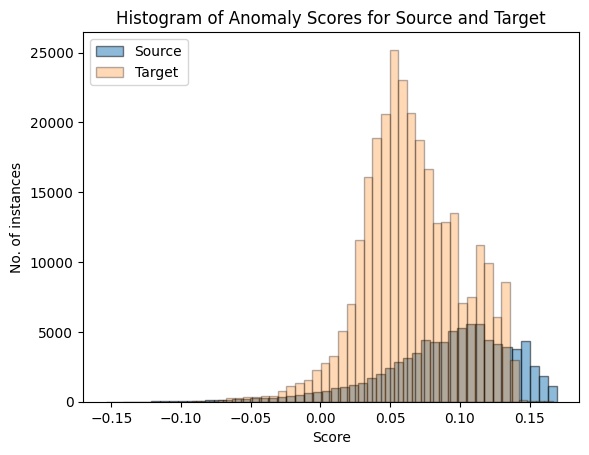

In [89]:
# Plotting histogram of scores for both source and target on the same plot
print(f"Estimated contamination in the source data: {estimated_contamination_scores}")
print(f"Estimated contamination in the target data: {estimated_contamination_scores_target}")

plt.hist(scores, bins=50, alpha=0.5, label='Source', edgecolor='k')
plt.hist(scores_target, bins=50, alpha=0.3, label='Target', edgecolor='k')

plt.title("Histogram of Anomaly Scores for Source and Target")
plt.xlabel("Score")
plt.ylabel("No. of instances")
plt.legend(loc='upper left')  # Display legend to differentiate between Source and Target
plt.show()

The results from the Isolation forest analysis reveal two main results:
- There is a shift between source and target distributions, as it can be seen in the combined histogram right above.
- The analysis is very sensitive to the predefined contamination *hyperparameter*. Plus, we cannot take the analysis as binary, i.e. instances as anomalies vs non-animales, as the threshold scores < 0 is somehow aleatoric. Let us focus on the distribution of scores rather on the number of instances above or below a given threshold.

### Unsupervised: statistical distance

As a final approach to quantify the domain shit, let us evaluate the statistical distance between the distributions of every feature in both populations. This will be an univariate analysis, so one needs to be cautious with the results. However, it will give a sense of which features are more heavily shifted.

In [11]:
# Prepare the data for modelling
df_modelling_phase1 = rsv_predictors_phase1_df[selected_features_v2]
df_modelling_labelled_phase2 = rsv_phase2_labelled_df[selected_features_v2]
df_modelling_all_phase2 = rsv_phase2_df[selected_features_v2_aux]

print(df_modelling_phase1.shape, df_modelling_labelled_phase2.shape, df_modelling_all_phase2.shape)

df_modelling_labelled_phase2.loc[:,'n_tests_that_day'] = pd.Categorical(df_modelling_labelled_phase2.n_tests_that_day, categories=[1,2])
df_modelling_all_phase2.loc[:,'n_tests_that_day'] = pd.Categorical(df_modelling_all_phase2.n_tests_that_day, categories=[1,2])


# Differentiate between source and target distributions
X_source = df_modelling_phase1.drop(['RSV_test_result'], axis = 1) # source distribution
labels_source = df_modelling_phase1['RSV_test_result']

X_target = df_modelling_all_phase2.copy() # target distribution

X_source.shape, X_target.shape

(86058, 21) (2867, 21) (291938, 20)


((86058, 20), (291938, 20))

Analyzing feature: n_tests_that_day


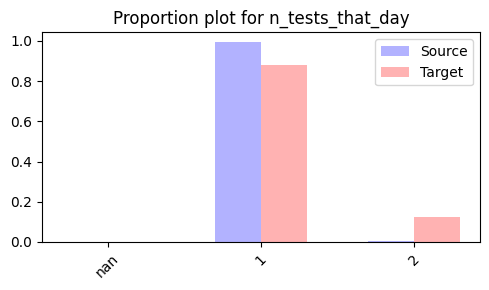

Chi-Squared Statistic: 0.0, P-value: 1.0


n_tests_that_day,1,2,Total
n_tests_that_day,,,
1,501,64,565
2,8,1,9
Total,509,65,574


Histogram Intersection: 0.8848554880579823


Analyzing feature: sine


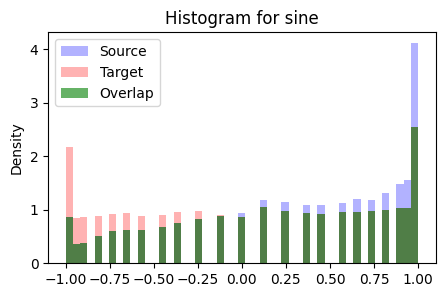

Overlap area: 0.8314528863734912
KS Statistic: 0.17928701338852898, P-value: 0.0
KL Divergence: 0.0881750007963962
Histogram Intersection: 20.517824665286778


Analyzing feature: cosine


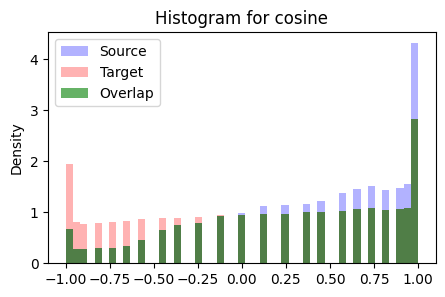

Overlap area: 0.8092059362145876
KS Statistic: 0.20194560168184406, P-value: 0.0
KL Divergence: 0.1046789878285303
Histogram Intersection: 20.230148405364684


Analyzing feature: previous_test_daydiff


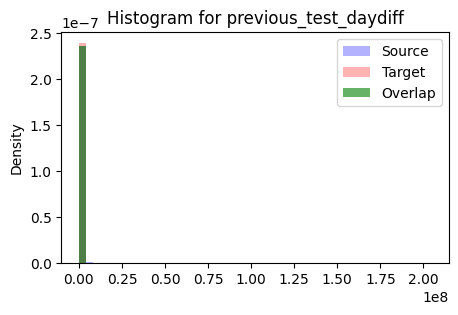

Overlap area: 0.988453125215532
KS Statistic: 0.3896416160337208, P-value: 0.0
KL Divergence: 0.03718161037886544
Histogram Intersection: 2.416461321246512e-07


Analyzing feature: Bronchitis


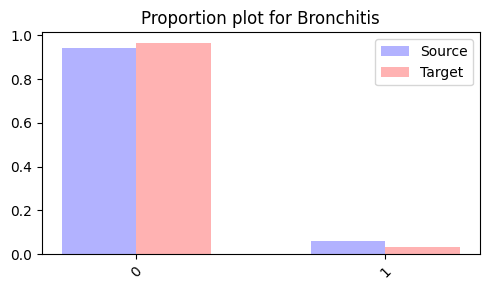

Chi-Squared Statistic: 0.29429249991327167, P-value: 0.5874828354514992


Bronchitis,0,1,Total
Bronchitis,,,
0,77960,3088,81048
1,4811,199,5010
Total,82771,3287,86058


Histogram Intersection: 0.9762942006550472


Analyzing feature: CCI


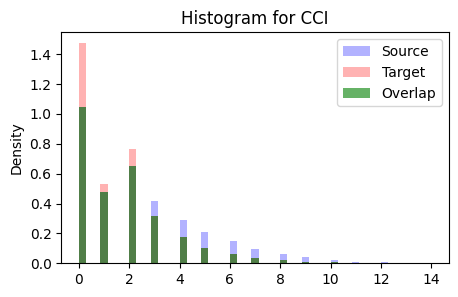

Overlap area: 0.8301542468681911
KS Statistic: 0.16984575313180905, P-value: 0.0
KL Divergence: 0.10560941159406086
Histogram Intersection: 2.9648365959578253


Analyzing feature: Acute_upper_respiratory_infection


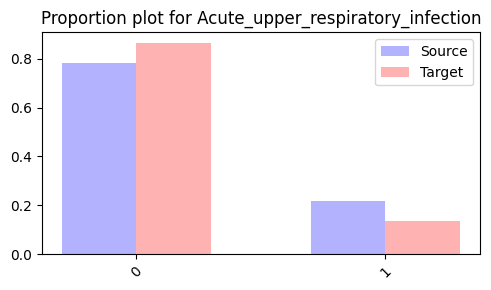

Chi-Squared Statistic: 0.05475719682264234, P-value: 0.8149829933391836


Acute_upper_respiratory_infection,0,1,Total
Acute_upper_respiratory_infection,,,
0,57810,9686,67496
1,15885,2677,18562
Total,73695,12363,86058


Histogram Intersection: 0.919364330771737


Analyzing feature: n_immunodeficiencies


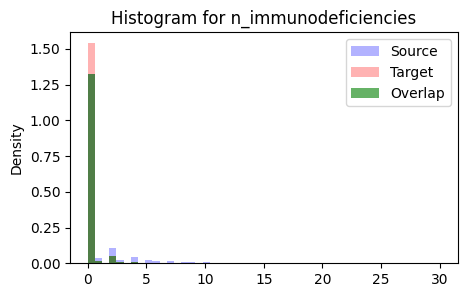

Overlap area: 0.8679889979673471
KS Statistic: 0.1320110020326527, P-value: 0.0
KL Divergence: 0.1758785779214902
Histogram Intersection: 1.446648329945579


Analyzing feature: n_symptoms


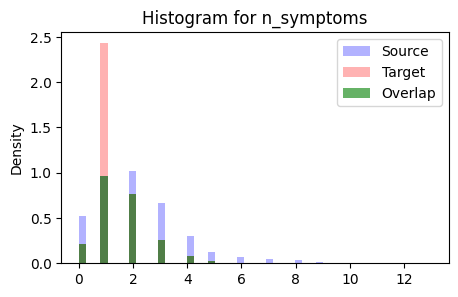

Overlap area: 0.6111800517076876
KS Statistic: 0.30541300882887584, P-value: 0.0
KL Divergence: 0.4933019368595684
Histogram Intersection: 2.3506925065680293


Analyzing feature: healthcare_seeking


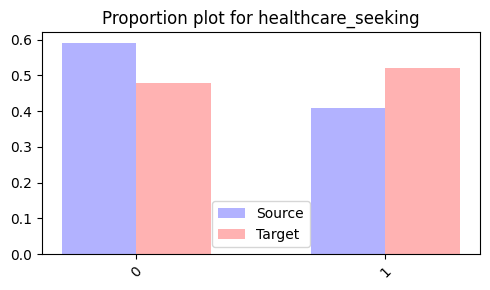

Chi-Squared Statistic: 3.6413736005491018, P-value: 0.056360417049871554


healthcare_seeking,0,1,Total
healthcare_seeking,,,
0,23551,27297,50848
1,16075,19135,35210
Total,39626,46432,86058


Histogram Intersection: 0.8882375475310875


Analyzing feature: General_symptoms_and_signs


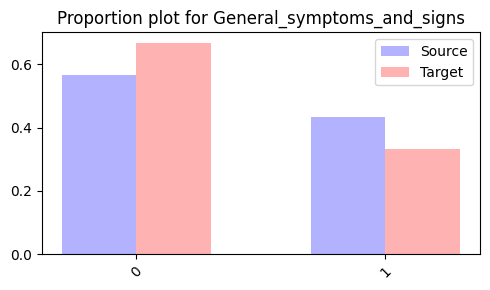

Chi-Squared Statistic: 3.526688138856745, P-value: 0.06038829914986209


General_symptoms_and_signs,0,1,Total
General_symptoms_and_signs,,,
0,31718,17070,48788
1,23999,13271,37270
Total,55717,30341,86058


Histogram Intersection: 0.8995659569717458


Analyzing feature: prev_positive_rsv


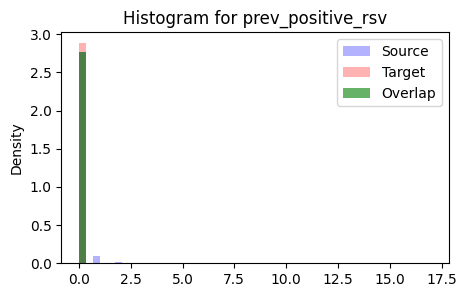

Overlap area: 0.95908461934316
KS Statistic: 0.04091538065683997, P-value: 4.0575744102341906e-97
KL Divergence: 0.1387833289996088
Histogram Intersection: 2.820837115715176


Analyzing feature: Influenza


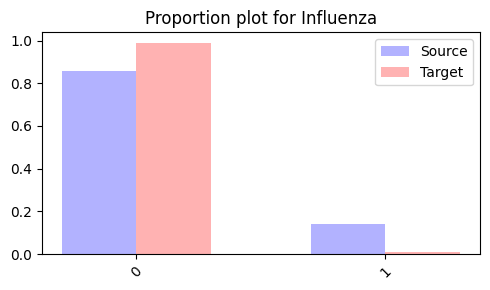

Chi-Squared Statistic: 0.16061725589325532, P-value: 0.6885888591090354


Influenza,0,1,Total
Influenza,,,
0,72879,867,73746
1,12173,139,12312
Total,85052,1006,86058


Histogram Intersection: 0.8677853150589379


Analyzing feature: key_comorbidities


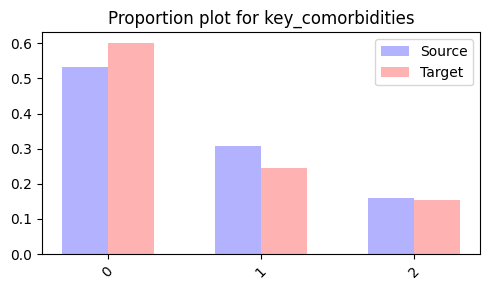

Chi-Squared Statistic: 6.016886824342675, P-value: 0.19789069963986394


key_comorbidities,0,1,2,Total
key_comorbidities,,,,
0,26598,11512,7811,45921
1,15055,6729,4605,26389
2,7951,3476,2321,13748
Total,49604,21717,14737,86058


Histogram Intersection: 0.9324981585947374


Analyzing feature: Pneumonia


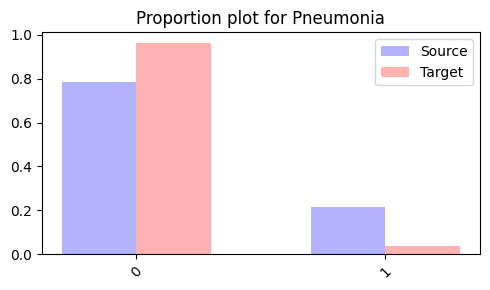

Chi-Squared Statistic: 0.4513756322235815, P-value: 0.5016824114815444


Pneumonia,0,1,Total
Pneumonia,,,
0,64997,2615,67612
1,17753,693,18446
Total,82750,3308,86058


Histogram Intersection: 0.8223694600997762


Analyzing feature: season


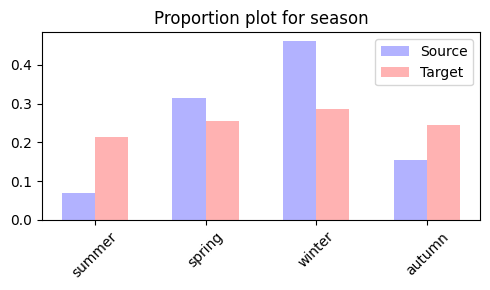

Chi-Squared Statistic: 12.44368050260501, P-value: 0.1894361750933032


season,autumn,spring,summer,winter,Total
season,,,,,
autumn,3205,3430,2951,3820,13406
spring,6721,7081,5776,7431,27009
summer,1468,1540,1303,1666,5977
winter,9559,10328,8629,11150,39666
Total,20953,22379,18659,24067,86058


Histogram Intersection: 0.7675147708896827


Analyzing feature: month_of_the_test


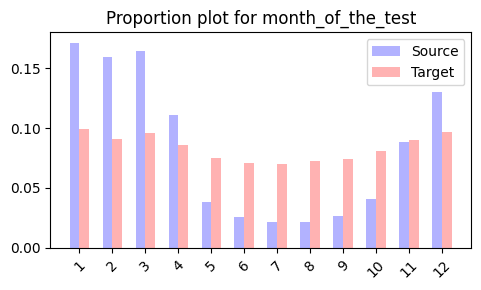

Chi-Squared Statistic: 109.1817322426709, P-value: 0.7711751482619138


month_of_the_test,1,2,3,4,5,6,7,8,9,10,11,12,Total
month_of_the_test,,,,,,,,,,,,,
1,1456,1277,1448,1300,1116,1098,988,1125,1088,1197,1256,1399,14748
2,1356,1238,1353,1197,1050,949,1018,995,972,1143,1177,1267,13715
3,1321,1246,1372,1314,1073,985,995,1027,1041,1172,1309,1290,14145
4,940,835,915,811,769,645,691,711,687,787,905,869,9565
5,335,282,287,295,245,249,226,247,249,288,283,313,3299
6,203,210,217,204,182,157,153,163,168,178,193,216,2244
7,188,187,163,149,132,130,137,150,143,169,163,169,1880
8,177,153,178,175,140,123,159,131,147,156,151,163,1853
9,230,231,217,181,170,163,162,175,156,195,190,214,2284


Histogram Intersection: 0.7312513513419436


Analyzing feature: multiple_tests


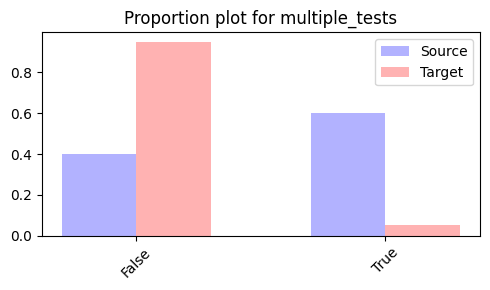

Chi-Squared Statistic: 5.461378091150648, P-value: 0.01944130799734349


multiple_tests,False,True,Total
multiple_tests,,,
False,32453,1837,34290
True,48800,2968,51768
Total,81253,4805,86058


Histogram Intersection: 0.4502885554651174


Analyzing feature: BPA


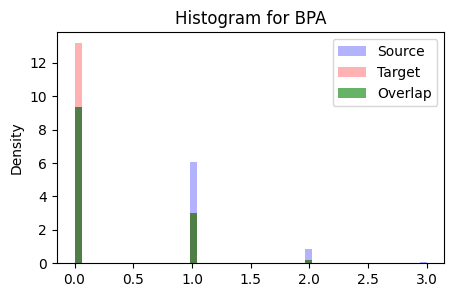

Overlap area: 0.7683272772849342
KS Statistic: 0.23167272271506556, P-value: 0.0
KL Divergence: 0.15763564771620603
Histogram Intersection: 12.805454621415572


Analyzing feature: BPAI


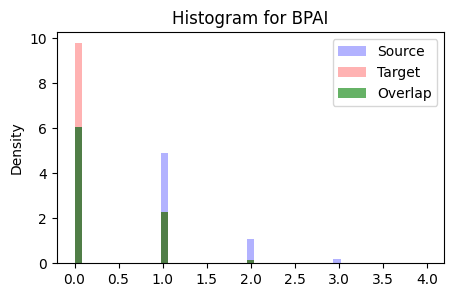

Overlap area: 0.6970224228376088
KS Statistic: 0.30297757716239154, P-value: 0.0
KL Divergence: 0.28833796058002775
Histogram Intersection: 8.712780285470105




In [55]:
list_of_features = list(X_target.columns)
list_of_categorical_flags = list((X_target.dtypes) == 'category')

for feature, is_categorical in zip(list_of_features, list_of_categorical_flags):
    analyze_feature(X_source, X_target, feature, categorical=is_categorical)


Overall, we can make the following remarks:
- There exists a **covariate shift** and a **label shift** but **not a concept shift**
- Covariate shift. Overall, the target population a) is more evenly spread through the year, b) presents less comorbidities and c) has a smaller presence of symptoms.
- Label shift. As a direct consequence of the covariate shift, the number of RSV positives will be smaller. This can already be seen in the small labelled subset. While the source population presented a 3.0% of positive tests, this subset presents a 1.8% of positivity.
- Concept drift. The fact that the model developed in phase 1 performs poorly on phase 2 data may reveal a concept drift. However, the lack of more labelled data, together with the domain knowledge, makes it less relevant to our specific case. Concept drift tend to happen in a) time series data or b) feedback-influenced cases (e.g. when the predictions of recommenders are affected by past recommendations)